Required packets

In [2]:
from darts import TimeSeries
from darts.metrics import mape, mse, mae
from darts.models import NaiveMean, NaiveSeasonal, NaiveDrift, NaiveMovingAverage, RandomForest, LinearRegressionModel, AutoARIMA, Theta, StatsForecastAutoETS, Prophet, NBEATSModel, NLinearModel
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

/home/filo/University/Thesis/Algorithm/wav_env/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


Load dataset as a series and prepare it by splitting into train and test

GPU is not available, using CPU


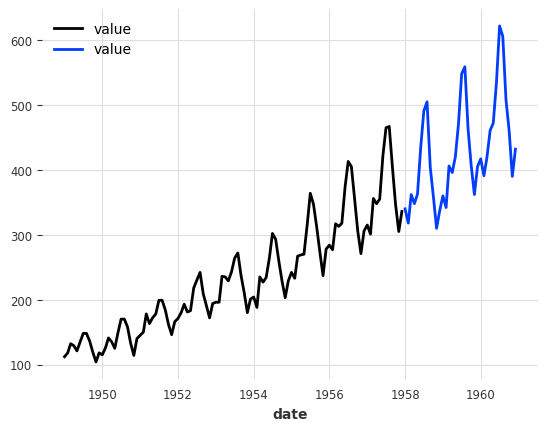

In [16]:
df = pd.read_csv('../dataset/monthly/airline-passengers.csv')
series = TimeSeries.from_dataframe(df, "date")
train, test = series.split_after(0.75)
train.plot()
test.plot()


df = pd.read_csv("../Dataset Preparation/final_dataset.csv")
series_w = TimeSeries.from_dataframe(df, "date")
train_w, test_w = series_w.split_after(0.75)



if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

In [13]:
def train_test_split(lst, percentage=80.0):
    # Calcola il numero di elementi da prendere
    num_elements = int(len(lst) * (percentage / 100.0))
    print(num_elements)
    # Prendi il numero desiderato di elementi
    return lst[:num_elements], lst[num_elements:]

df = pd.read_csv("../Dataset Preparation/final_dataset.csv", header=0, index_col=0)
df.index = pd.to_datetime(df.index)
series = TimeSeries.from_dataframe(df, time_col=0)
time_index = series.time_index
header = series.columns
lst_series = []
for column in header:
    tmp_series = series.univariate_component(column).values()
    train_w, test_w = train_test_split(tmp_series, 80.0)
    start_index = 1
    for i in range(0, len(train_w)-1):
        if np.isnan(train_w[i]) and np.isnan(train_w[i+1]) == False:
            start_index = i + 1
        if np.isnan(train_w[i]) == False and np.isnan(train_w[i+1]) and start_index != 0:
            end_index = i
            if end_index - start_index > 24:
                res = series.univariate_component(column).slice(start_ts=time_index[start_index], end_ts=time_index[end_index])
                lst_series.append(res)
            start_index = 0

115


## Naive Models - baseline

In [ ]:
model0 = NaiveMean()
model1 = NaiveSeasonal(K = 24)
model2 = NaiveDrift()
model3 = NaiveMovingAverage(input_chunk_length = 24)

models = {
    "Mean": model0,
    "Seasonal": model1,
    "Drift": model2,
    "MA": model3
}

In [ ]:
fig = plt.figure(figsize=(16, 10))
for i, (name, model) in tqdm(enumerate(models.items()), desc="Progress"):
  print(name)
  model.fit(series=train)
  predictions = model.predict(n = len(test))
  mae_score = round(mae(test, predictions), 2)
  mse_score = round(mse(test, predictions), 2)

  fig.add_subplot(2, 2, i+1)
  train.plot(label="train"); test.plot(label="test"); predictions.plot(label=name)
  plt.title(f"Method: {name}, MAE: {mae_score}, MSE: {mse_score} with sample selection"); plt.legend()
fig.tight_layout()
plt.show()

## Classical models

In [14]:
model0 = Theta()
model1 = LinearRegressionModel(lags=24)
model2 = StatsForecastAutoETS()
model3 = AutoARIMA(start_p=2, max_p=12, start_q=1)
model4 = RandomForest(lags=24, n_estimators=300)
model5 = Prophet()

models = {
    #"Theta": model0,
    "Linear": model1,
    "Exponential": model2,
    "ARIMA": model3,
    "RandomForest": model4,
    "Prophet": model5
}

Progress: 2it [00:00, 12.48it/s]

Linear
Exponential
ARIMA
RandomForest


Progress: 4it [00:05,  1.55s/it]21:15:57 - cmdstanpy - INFO - Chain [1] start processing
21:15:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet


Progress: 5it [00:05,  1.19s/it]


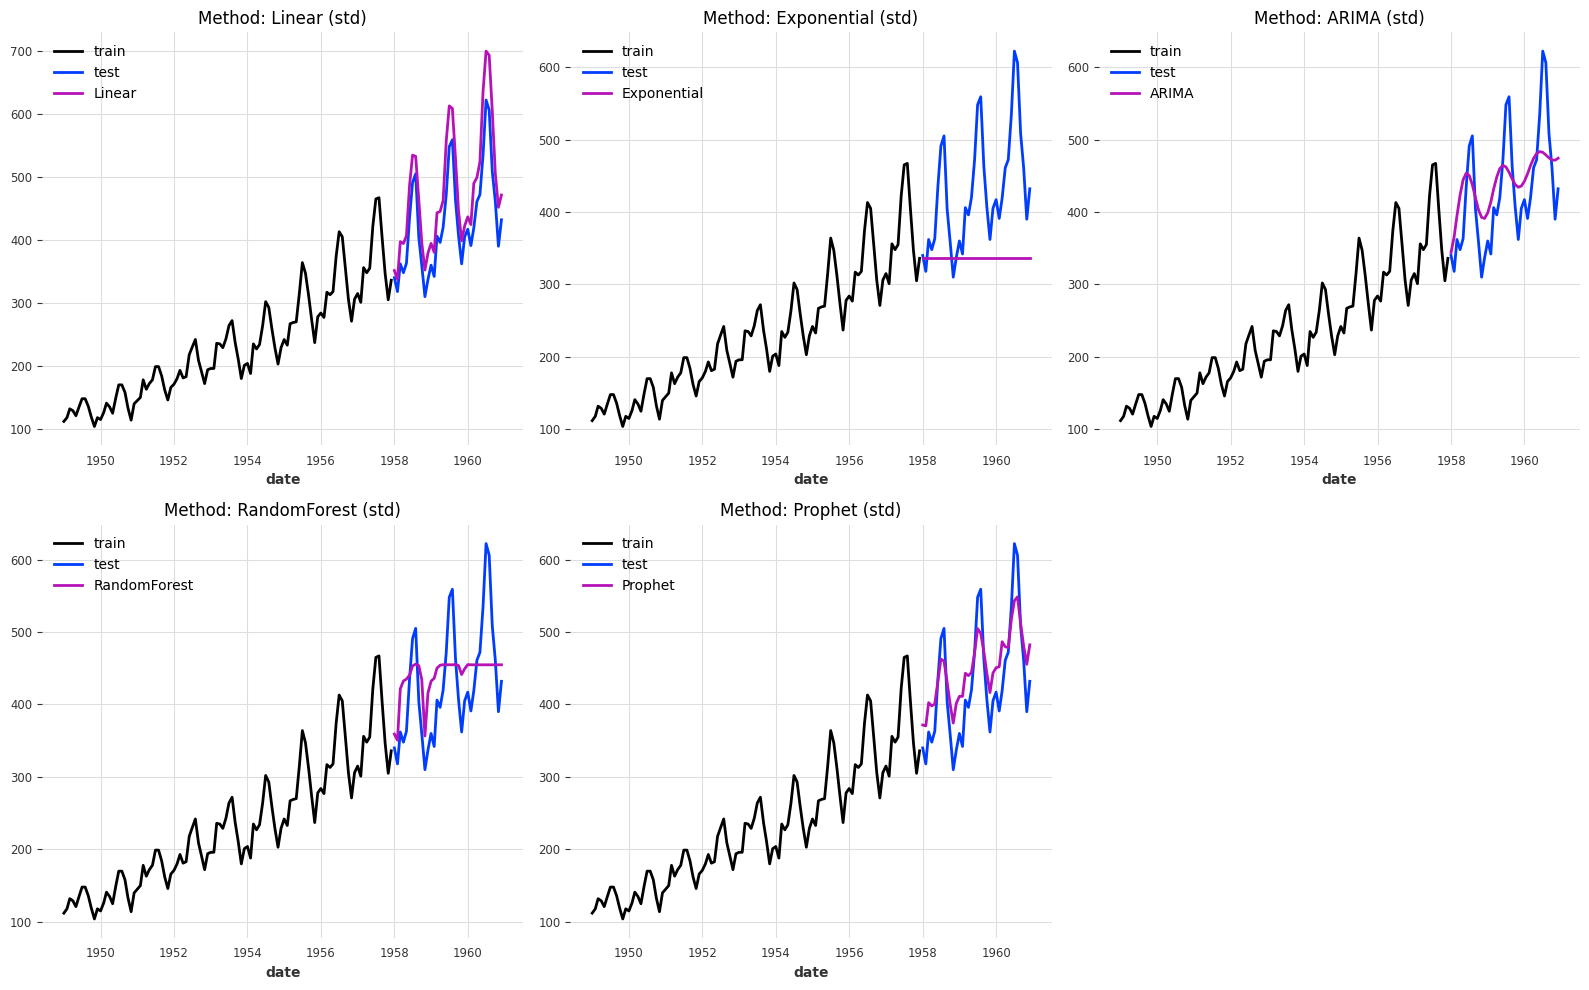

Linear
Exponential
ARIMA
RandomForest


21:16:04 - cmdstanpy - INFO - Chain [1] start processing


Prophet


21:16:04 - cmdstanpy - INFO - Chain [1] done processing


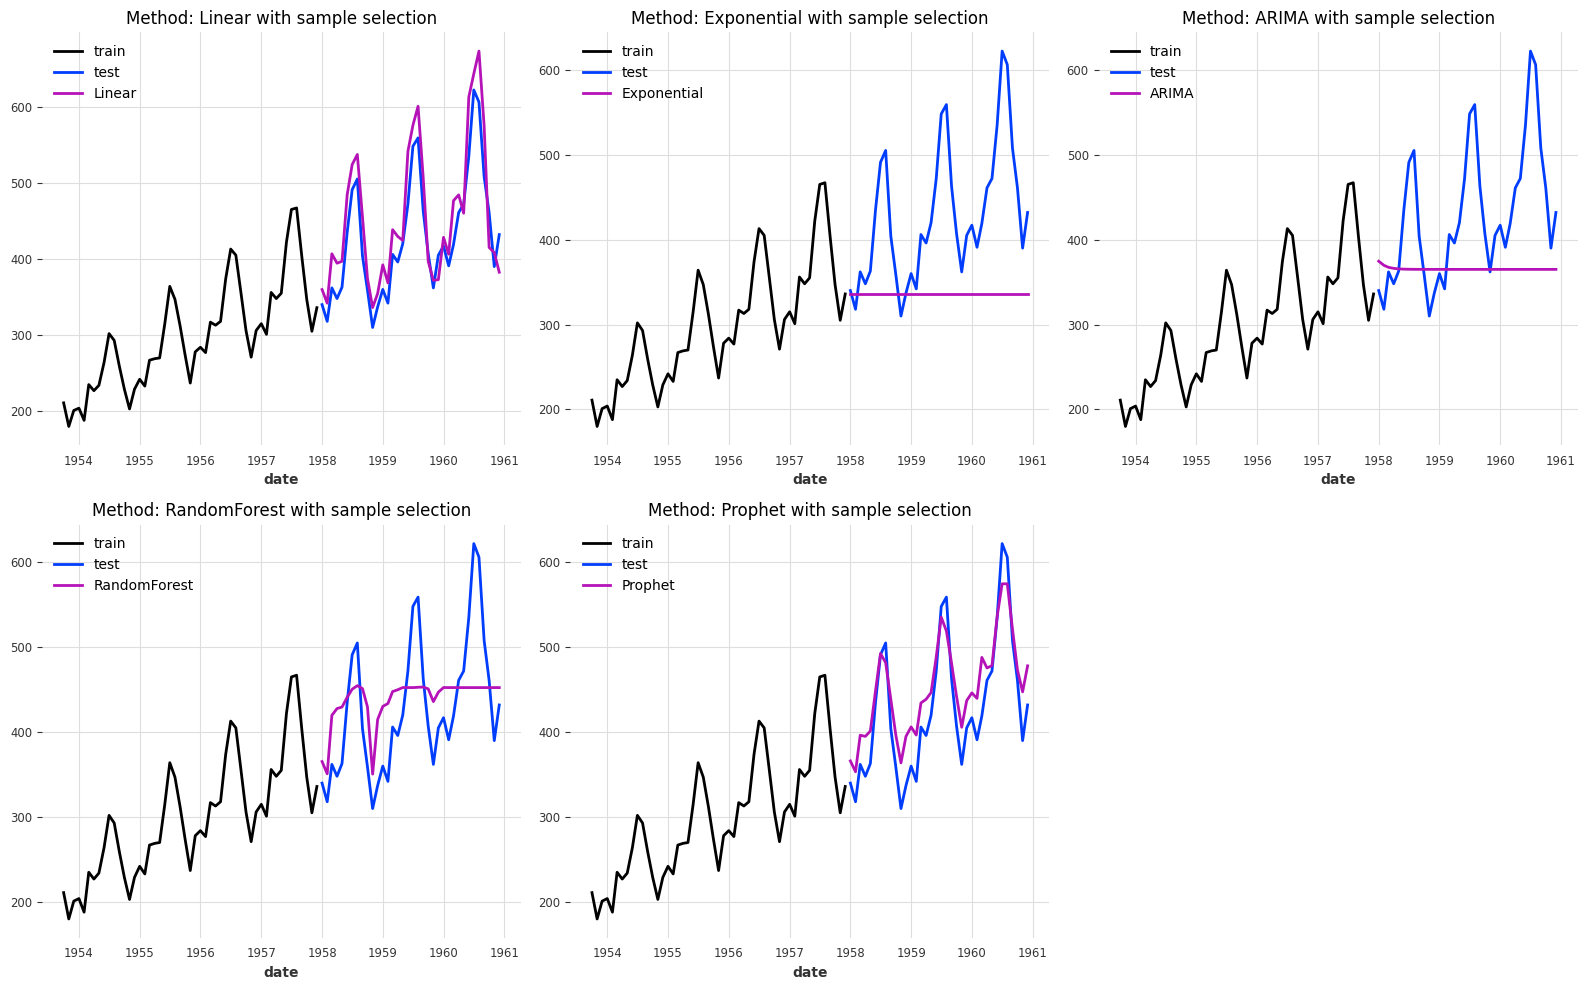

In [17]:
mae_list = []
mse_list = []
fig = plt.figure(figsize=(16, 10))
for i, (name, model) in tqdm(enumerate(models.items()), desc="Progress"):
  print(name)
  model.fit(series=train)
  predictions = model.predict(n = len(test))
  mae_score = round(mae(test, predictions), 5)
  mae_list.append([mae_score, name])
  mse_score = round(mse(test, predictions), 5)
  mse_list.append([mse_score, name])
  # mae_score = mae(test, predictions)
  # mse_score = mse(test, predictions)

  fig.add_subplot(2, 3, i+1)
  train.plot(label="train"); test.plot(label="test"); predictions.plot(label=name)
  plt.title(f"Method: {name} (std)"); plt.legend()
fig.tight_layout()
plt.savefig('w_o.png')
plt.show()

fig = plt.figure(figsize=(16, 10))
for i, (name, model) in enumerate(models.items()):
  print(name)
  model.fit(series=train_w[58:])
  predictions = model.predict(n = len(test))
  mae_score = round(mae(test, predictions), 5)
  mae_list.append([mae_score, name])
  mse_score = round(mse(test, predictions), 5)
  mse_list.append([mse_score, name])
  # mae_score = mae(test, predictions)
  # mse_score = mse(test, predictions)

  fig.add_subplot(2, 3, i+1)
  train_w.plot(label="train"); test.plot(label="test"); predictions.plot(label=name)
  plt.title(f"Method: {name} with sample selection"); plt.legend()
fig.tight_layout()
plt.savefig('w.png')
plt.show()

In [18]:
print(mae_list)
print(mse_list)

[[48.30305, 'Linear'], [94.9472, 'Exponential'], [49.48831, 'ARIMA'], [55.92333, 'RandomForest'], [39.86754, 'Prophet'], [33.96808, 'Linear'], [94.9472, 'Exponential'], [75.90218, 'ARIMA'], [55.21991, 'RandomForest'], [32.69824, 'Prophet']]
[[2780.84217, 'Linear'], [14675.12899, 'Exponential'], [3505.37166, 'ARIMA'], [4461.34483, 'RandomForest'], [2011.09625, 'Prophet'], [1493.44201, 'Linear'], [14675.12899, 'Exponential'], [10182.35812, 'ARIMA'], [4370.38003, 'RandomForest'], [1349.32829, 'Prophet']]


## Deep Learning models

In [27]:
model6 = NBEATSModel(
    input_chunk_length = 12,
    output_chunk_length= 4,
    num_stacks = 3,
    num_blocks = 1,
    num_layers = 2,
    layer_widths = 32,
    n_epochs = 150,
    batch_size = 12,
    #pl_trainer_kwargs={"accelerator": "gpu", "devices": -1}
)

model7 = NLinearModel(
    input_chunk_length=12,
    output_chunk_length=4,
    n_epochs=150,
    #pl_trainer_kwargs={"accelerator": "gpu", "devices": -1}
)

models = {
    "NBEATS": model6,
    "NLinear": model7
}

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 5.7 K 
---------------------------------------------------
5.5 K     Trainable params
237       Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


NBEATS


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 52    
---------------------------------------------------
52        Trainable params
0         Non-trainable params
52        Total params
0.000     Total estimated model params size (MB)


NLinear


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

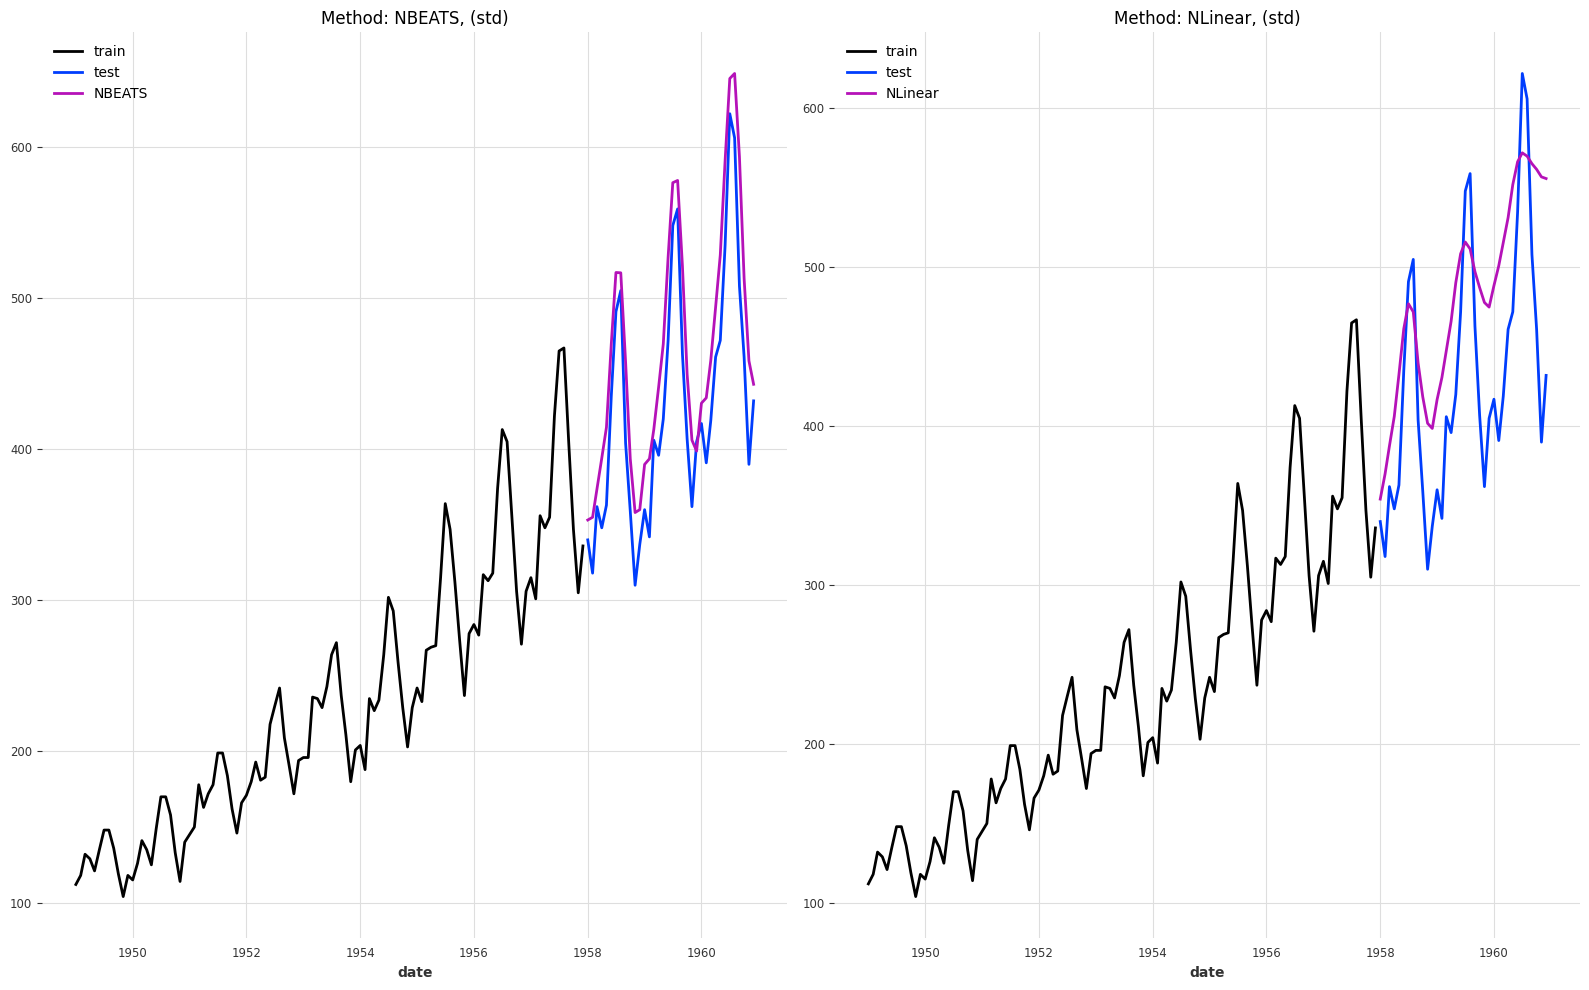

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 5.7 K 
---------------------------------------------------
5.5 K     Trainable params
237       Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


NBEATS


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 52    
---------------------------------------------------
52        Trainable params
0         Non-trainable params
52        Total params
0.000     Total estimated model params size (MB)


NLinear


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

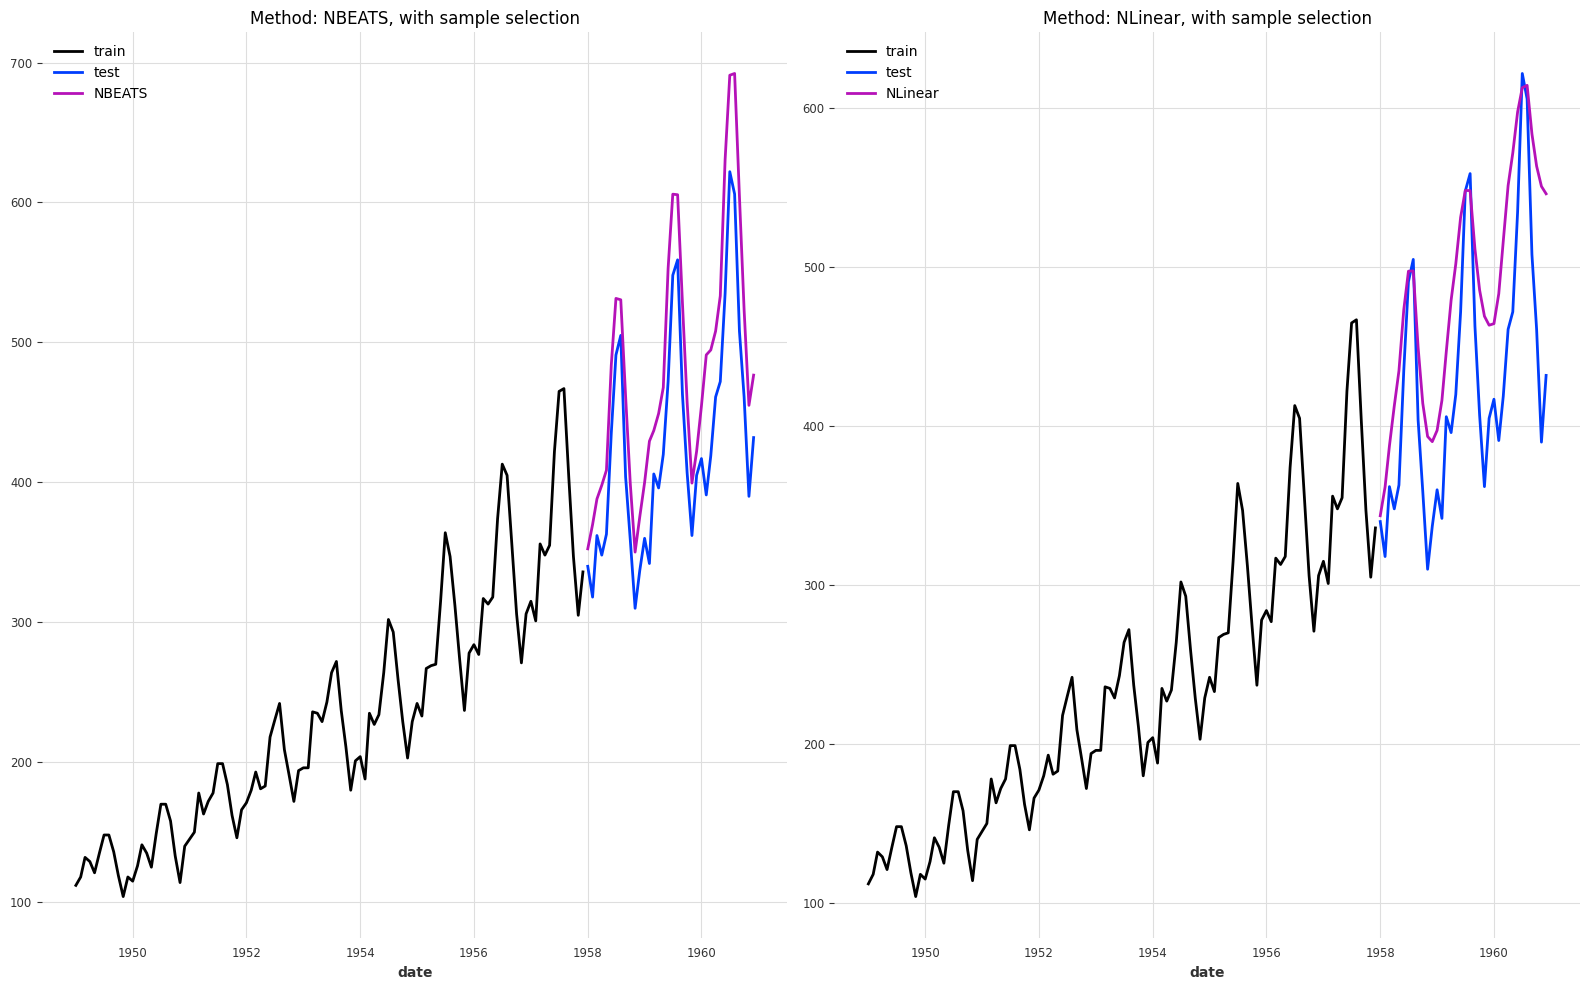

In [28]:
mae_list = []
mse_list = []
fig = plt.figure(figsize=(16, 10))
for i, (name, model) in enumerate(models.items()):
  print(name)
  model.fit(series=train)
  predictions = model.predict(n = len(test))
  mae_score = round(mae(test, predictions), 5)
  mae_list.append([mae_score, name])
  mse_score = round(mse(test, predictions), 5)
  mse_list.append([mse_score, name])
  # mae_score = mae(test, predictions)
  # mse_score = mse(test, predictions)

  fig.add_subplot(1, 2, i+1)
  train.plot(label="train"); test.plot(label="test"); predictions.plot(label=name)
  plt.title(f"Method: {name}, (std)"); plt.legend()
fig.tight_layout()
plt.savefig('nn_wo.png')
plt.show()

fig = plt.figure(figsize=(16, 10))
for i, (name, model) in enumerate(models.items()):
  print(name)
  model.fit(series=train_w[58:])
  predictions = model.predict(n = len(test))
  mae_score = round(mae(test, predictions), 5)
  mae_list.append([mae_score, name])
  mse_score = round(mse(test, predictions), 5)
  mse_list.append([mse_score, name])

  fig.add_subplot(1, 2, i+1)
  train.plot(label="train"); test.plot(label="test"); predictions.plot(label=name)
  plt.title(f"Method: {name}, with sample selection"); plt.legend()
fig.tight_layout()
plt.savefig('nn_w.png')
plt.show()

In [29]:
print(mae_list)
print(mse_list)

[[37.55817, 'NBEATS'], [63.33255, 'NLinear'], [53.67899, 'NBEATS'], [59.54889, 'NLinear']]
[[1751.64228, 'NBEATS'], [5092.75869, 'NLinear'], [3345.68707, 'NBEATS'], [4883.24029, 'NLinear']]
